In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists
import numpy as np
import PIL
import matplotlib.pyplot as plt
from glob import glob
import cv2
from natsort import natsorted

import shared_utils as su

In [3]:
data_dir = "../data/datasets/pouring_dataset/"

image_dir = join(data_dir, "fakeB")
amask_dir = join(data_dir, "trainA_liquid_masks")

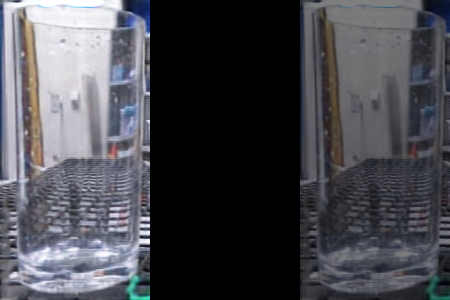

In [7]:
i = 0

image_path = join(image_dir, f"rgb_{i}.png")
assert exists(image_path)
image = PIL.Image.open(image_path)
image = image.resize((150, 300))

amask_path = join(amask_dir, f"liquid_mask_{i}.npy")
assert exists(amask_path)
amask_threshold = 0.95
amask = np.load(amask_path)
amask[amask < amask_threshold] = 0.
amask_pil = PIL.Image.fromarray(np.clip(amask * 255., 0, 255).astype(np.uint8))

image_with_amask = su.viz.add_mask_on_image(image, amask_pil, color="blue")

su.viz.concat_images(
    [image, amask_pil, image_with_amask]
)

### Dev code

In [5]:
gt_images = natsorted(glob(join(data_dir, "fakeB/*.png")))
mask_images = natsorted(glob(join(data_dir, "trainA/*.jpg")))

mask_dir = join(data_dir, "trainA_liquid_masks")
mask_paths = natsorted(glob(join(mask_dir, "*.npy")))

assert len(gt_images) == len(mask_images)
n_images = len(gt_images)

In [6]:
n_images

2231

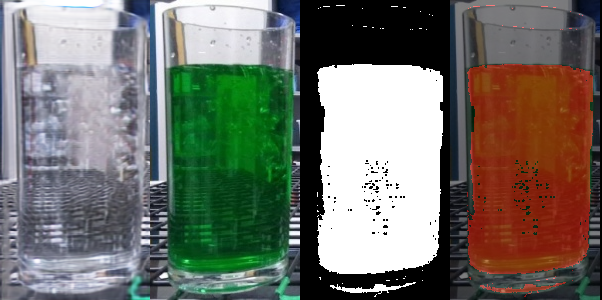

In [7]:
# i = np.random.randint(n_images)
i = 50

transp_img = PIL.Image.open(gt_images[i])
opaque_img = PIL.Image.open(mask_images[i])
mask = np.load(mask_paths[i])
mask[mask < 0.95] = 0.
mask_pil = PIL.Image.fromarray(np.clip(mask * 255., 0, 255).astype(np.uint8))
opaque_img_with_mask = su.viz.add_mask_on_image(opaque_img, mask_pil, color="red")

su.viz.concat_images(
    [transp_img, opaque_img, mask_pil, opaque_img_with_mask]
)